# Universal Classification Model

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [4]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt

In [5]:
from pycaret.classification import *

In [6]:
import functions as f

In [7]:
from copy import deepcopy

In [8]:
categorical_columns = ['NP_type', 'Coating','shape','Cell_name','Cell_species','cell_Organ','Cell_morphology',
                       'Cell_age','cell_type','sex','Assay','Test_indicator']
numerical_columns = ['core_size_nm','hydro_size_nm','Surf_charge_mV','Surface_area_m2_g','Dose_microg_mL','Duration_h',
                    'Viability']

numerical_columns_no_target = ['core_size_nm','hydro_size_nm','Surf_charge_mV','Surface_area_m2_g','Dose_microg_mL','Duration_h']

### Loading the train data into the data frame.

In [9]:
data_train_df = pd.read_csv("output/datasets/universal/data_classification_train_df.csv", encoding="utf-8")

In [10]:
data_train_df.dtypes

NP_type                object
Coating                object
core_size_nm          float64
hydro_size_nm         float64
Surf_charge_mV        float64
Surface_area_m2_g     float64
shape                  object
Dose_microg_mL        float64
Duration_h            float64
Cell_name              object
Cell_species           object
cell_Organ             object
Cell_morphology        object
Cell_age               object
cell_type              object
sex                    object
Assay                  object
Test_indicator         object
nanomaterial_group     object
viability_class        object
dtype: object

In [11]:
data_train_df.shape

(3724, 20)

In [12]:
data_train_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,viability_class
0,Carbon,None,53.7,NaN,-39.90,NaN,Sphere,50.00,24.0,THP_1,Human,Blood,monocyte,neonate,cancer,male,MTT,TetrazoliumSalt,carbon,NonToxic
1,TiO2,None,30.6,266.0,NaN,NaN,Sphere,2.50,24.0,WISH,Human,Amniotic-membrane,Epithelial,fetus,cancer,NaN,MTT,TetrazoliumSalt,meta_oxide,NonToxic
2,IronOxide,PEG_based,35.8,NaN,-0.52,NaN,Sphere,6.25,48.0,SKOV­3,Human,Ovary,Epithelial,Young,cancer,female,MTS,TetrazoliumSalt,meta_oxide,NonToxic
3,ZnO,None,141.0,404.0,NaN,NaN,Sphere,10.00,9.0,SIRC,Rabbit,Cornea,Fibroblast,Adult,Normal,NaN,MTT,TetrazoliumSalt,meta_oxide,NonToxic
4,TiO2,None,40.0,322.3,-25.27,50.0,NaN,0.00,12.0,L-02,Human,Liver,Epithelial,Adult,cancer,female,ATPLite,luciferase,meta_oxide,NonToxic


In [13]:
#data_train_df_clean = data_train_df.dropna(thresh=data_train_df.shape[1]-3, axis=0)
#print(data_train_df_clean.shape)

### Loading the test data into the data frame.

In [14]:
data_test_df = pd.read_csv("output/datasets/universal/data_classification_test_df.csv", encoding="utf-8")

In [15]:
data_test_df.dtypes

NP_type                object
Coating                object
core_size_nm          float64
hydro_size_nm         float64
Surf_charge_mV        float64
Surface_area_m2_g     float64
shape                  object
Dose_microg_mL        float64
Duration_h            float64
Cell_name              object
Cell_species           object
cell_Organ             object
Cell_morphology        object
Cell_age               object
cell_type              object
sex                    object
Assay                  object
Test_indicator         object
nanomaterial_group     object
viability_class        object
dtype: object

In [16]:
data_test_df.shape

(932, 20)

In [17]:
data_test_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,viability_class
0,SWCNT,None,16.4,NaN,-9.72,NaN,Needle,200.0,24.0,A549,Human,Lung,Epithelial,Adult,cancer,male,MTS,TetrazoliumSalt,nanotubes,NonToxic
1,ZnO,None,100.0,258.55,-9.96,NaN,Sphere,80.0,24.0,SH­SY5Y,Human,BoneMarrow,Epithelial,Young,cancer,female,MTT,TetrazoliumSalt,meta_oxide,Toxic
2,SiO2,NH2,NaN,437.00,21.70,NaN,NaN,0.0,12.0,PC12,Rat,Adrenal-gland,Irregular,Adult,cancer,male,MTT,TetrazoliumSalt,meta_oxide,NonToxic
3,Ag,Citrate_based,50.0,NaN,-20.00,NaN,Sphere,12.5,24.0,HDF,Human,Skin,Fibroblast,Adult,Normal,NaN,MTS,TetrazoliumSalt,other,NonToxic
4,ZrO2,None,40.1,508.80,-14.85,NaN,Monoclinic,12.5,24.0,THP_1,Human,Blood,monocyte,neonate,cancer,male,MTS,TetrazoliumSalt,meta_oxide,NonToxic


In [18]:
#data_test_df_clean = data_test_df.dropna(thresh=data_test_df.shape[1]-3, axis=0)
#print(data_test_df_clean.shape)

### Use the best scenario identified in step 01

In [19]:
sc_ignore_features = None
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'simple'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = False

### Define seeds

In [20]:
cv_inner_seed = 123456
cv_outer_seed = 123

### The Universal Classification Model: Data Preprcoessing

In [21]:
stup = setup(data = data_train_df, target = 'viability_class', 
              
        test_data = data_test_df,
             
        categorical_features=categorical_columns,
        numeric_features=numerical_columns_no_target,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        fix_imbalance = True,
        fold = 5,

        # don't change the following
        session_id = cv_inner_seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'universal')

set_config('seed', cv_inner_seed)

,Description,Value
0,session_id,123456
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,"NonToxic: 0, Toxic: 1"
4,Original Data,"(3724, 20)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,13
8,Ordinal Features,False
9,High Cardinality Features,False


In [22]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(3724, 247)
(3724,)


In [23]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(3724, 247)
(3724,)


In [24]:
#set_config('X_train', get_config(variable="X").copy()) 
#set_config('y_train', get_config(variable="y").copy()) 
#print(get_config(variable="X_train").shape)
#print(get_config(variable="y_train").shape)

In [25]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(932, 247)
(932,)


In [26]:
#load_config('output/models/universal_classification_config.cfg')

In [27]:
data_train_transformed_df = get_config(variable="X").copy()
data_train_transformed_df['Viability'] = get_config(variable="y").copy()

In [28]:
data_test_transformed_df = get_config(variable="X_test").copy()
data_test_transformed_df['Viability'] = get_config(variable="y_test").copy()

In [29]:
data_train_transformed_df.to_csv('output/datasets/universal/transformed/data_classification_train_transformed_df.csv', encoding='utf-8', index=False)
data_test_transformed_df.to_csv('output/datasets/universal/transformed/data_classification_test_transformed_df.csv', encoding='utf-8', index=False)

## Double cross-validation

### Inner CV: 5-fold cross-validation for model selection / hyperparameter tuning for 7 models

In [30]:
model_names = ['lr', 'knn', 'svm', 'rf', 'et', 'gbc', 'lightgbm']

In [31]:
inner_results = dict()
inner_results_tuned = dict()
outer_results = dict()
predicted_results = dict()
tuned_models = dict()
final_models = dict()

In [32]:
for model_name in model_names:

    default_model = create_model(model_name, round=2)

    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    inner_results[model_name] = results_df.copy()
    results_df.to_csv("output/models_results/universal/" + "classification_model_"+model_name+"_inner_cross_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")


    tuned_model = tune_model(default_model, choose_better = True, search_library = 'optuna', n_iter = 50, round=2)

    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    inner_results_tuned[model_name] = results_df.copy()
    results_df.to_csv("output/models_results/universal/" + "classification_model_"+model_name+"_tuned_inner_cross_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")
    
    tuned_models[model_name] = deepcopy(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.93,0.96,0.81,0.85,0.83,0.79,0.79
1,0.92,0.96,0.78,0.83,0.80,0.75,0.76
2,0.94,0.97,0.79,0.89,0.84,0.80,0.80
3,0.91,0.96,0.78,0.79,0.78,0.73,0.73
4,0.93,0.96,0.83,0.85,0.84,0.80,0.80
Mean,0.93,0.96,0.79,0.84,0.82,0.77,0.77
Std,0.01,0.00,0.02,0.03,0.02,0.03,0.03


### Outer CV: 10-fold cross-validation for the tuned model

In [33]:
X = get_config(variable="X_train").copy()
y = get_config(variable="y_train").copy()

In [34]:
X.shape

(3724, 247)

In [35]:
y.shape

(3724,)

In [36]:
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=cv_outer_seed)

In [37]:
for model_name in model_names:
    scores = cross_validate(tuned_models[model_name], X, y, cv=cv_outer, scoring=('f1','accuracy','roc_auc'))
    scores_f1 = np.round(scores['test_f1'], 2);
    scores_accuracy = np.round(scores['test_accuracy'], 2);
    scores_roc_auc = np.round(scores['test_roc_auc'], 2);
    outer_results[model_name] = scores.copy()
    
    with open("output/models_results/universal/" + "classification_model_"+model_name+"_tuned_outer_cross_validation_results.tsv", 'w', newline='') as file:
        file.write('F1\tAccuracy\tAUC' + "\n")
        for idx, x in enumerate(scores_f1):
            file.write(str(scores_f1[idx]) + '\t' + str(scores_accuracy[idx]) + '\t' + str(scores_roc_auc[idx]) + "\n")

    print(model_name + " scores: " + ', '.join(scores_f1.astype('str')))
    print(model_name + " mean/std: " + str(np.round(scores_f1.mean(),2)) + " / " + str(np.round(scores_f1.std(), 2)))
    
    #with open(the_filename, 'r') as f:
    #    my_list = [line.rstrip('\n') for line in f]

lr scores: 0.66, 0.61, 0.65, 0.6, 0.69, 0.63, 0.66, 0.62, 0.57, 0.72
lr mean/std: 0.64 / 0.04
knn scores: 0.73, 0.68, 0.74, 0.7, 0.73, 0.72, 0.75, 0.71, 0.66, 0.72
knn mean/std: 0.71 / 0.03
svm scores: 0.62, 0.54, 0.64, 0.65, 0.6, 0.55, 0.66, 0.55, 0.58, 0.61
svm mean/std: 0.6 / 0.04
rf scores: 0.79, 0.76, 0.77, 0.71, 0.79, 0.74, 0.78, 0.79, 0.72, 0.77
rf mean/std: 0.76 / 0.03
et scores: 0.77, 0.73, 0.74, 0.68, 0.76, 0.74, 0.79, 0.76, 0.72, 0.74
et mean/std: 0.74 / 0.03
gbc scores: 0.79, 0.77, 0.77, 0.75, 0.87, 0.78, 0.86, 0.8, 0.83, 0.79
gbc mean/std: 0.8 / 0.04
[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fraction is set=0.7450419954756938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450419954756938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] 

### Finalize the models and evaluate on the test set

In [38]:
for model_name in model_names:

    final_model = finalize_model(tuned_models[model_name])
    
    final_models[model_name] = deepcopy(final_model)
    
    hyperparams = pd.DataFrame.from_dict(final_model.get_params(), orient='index', columns=['parameter_value'])
    hyperparams = hyperparams.reset_index(level=0)
    hyperparams.to_csv("output/models_parameters/universal/" + "classification_model_"+model_name+"_hyperparams.tsv", 
                    index=False, encoding="utf-8", sep="\t")
    
    model_predict = predict_model(final_model, round=2)
    
    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    predicted_results[model_name] = results_df.copy()
    results_df.to_csv("output/models_results/universal/" + "classification_model_"+model_name+"_test_set_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.81,0.90,0.84,0.53,0.65,0.53,0.55


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.91,0.84,0.72,0.81,0.76,0.70,0.71


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.83,0.74,0.59,0.59,0.59,0.48,0.48


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.93,0.97,0.78,0.87,0.82,0.78,0.78


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.91,0.96,0.75,0.81,0.78,0.73,0.73


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.94,0.97,0.88,0.83,0.85,0.81,0.81


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.94,0.97,0.87,0.84,0.86,0.82,0.82


### Save models and configs

In [39]:
save_config('output/models/universal/classification_config.cfg')

for model_name in model_names:
    save_model(tuned_models[model_name], 'output/models/universal/classification_model_'+model_name+'_tuned.mdl')
    save_model(final_models[model_name], 'output/models/universal/classification_model_'+model_name+'_final.mdl')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


### Create Plots

In [40]:
X_test = get_config(variable="X_test").copy()
y_test = get_config(variable="y_test").copy()

In [41]:
for model_name in ['rf', 'et', 'gbc', 'lr']:
    
    #import matplotlib.pyplot as plt
    #plt.rcParams["figure.figsize"] = [16,9]

    visualizer1 = FeatureImportances(final_models[model_name], size=(800,550), topn=10)
    visualizer1.fit(X, y)
    visualizer1.show(outpath="output/plots/universal/" + "classification_model_"+model_name+"_feature_importance_plot.png",dpi = 300)

    plt.clf() 

<Figure size 800x550 with 0 Axes>

In [42]:
for model_name in model_names:

    visualizer2 = PrecisionRecallCurve(final_models[model_name], hist=False, qqplot=True, size=(800,550))
    visualizer2.fit(X, y)
    visualizer2.score(X_test, y_test)
    visualizer2.show(outpath="output/plots/universal/" + "classification_model_"+model_name+"_PrecisionRecallCurve_plot.png",dpi = 300)
    
    plt.clf() 

<Figure size 800x550 with 0 Axes>

In [43]:
for model_name in model_names:

    visualizer3 = ClassPredictionError(final_models[model_name], size=(800,550))
    visualizer3.fit(X, y)
    visualizer3.score(X_test, y_test)
    visualizer3.show(outpath="output/plots/universal/" + "classification_model_"+model_name+"_error_plot.png",dpi = 300)    
    
    plt.clf()

<Figure size 800x550 with 0 Axes>

In [44]:
for model_name in model_names:

    visualizer4 = ConfusionMatrix(final_models[model_name], size=(800,550), percent=True)
    visualizer4.fit(X, y)
    visualizer4.score(X_test, y_test)
    for label in visualizer4.ax.texts:
        label.set_size(18)
    visualizer4.show(outpath="output/plots/universal/" + "classification_model_"+model_name+"_ConfusionMatrix_plot.png",dpi = 300)    
    
    plt.clf()

<Figure size 800x550 with 0 Axes>

In [45]:
for model_name in model_names:

    visualizer5 = DiscriminationThreshold(final_models[model_name], size=(800,550))
    visualizer5.fit(X, y)
    visualizer5.score(X_test, y_test)
    visualizer5.show(outpath="output/plots/universal/" + "classification_model_"+model_name+"_DiscriminationThreshold_plot.png",dpi = 300)    
    
    plt.clf()

[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fraction is set=0.7450419954756938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450419954756938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fraction is set=0.7450419954756938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450419954756938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fracti

[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fraction is set=0.7450419954756938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450419954756938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fraction is set=0.7450419954756938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450419954756938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fracti

[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fraction is set=0.7450419954756938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450419954756938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fraction is set=0.7450419954756938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450419954756938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8120670484873849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8120670484873849
[LightGBM] [Warning] feature_fracti

<Figure size 800x550 with 0 Axes>

In [46]:
for model_name in ['lr', 'knn', 'rf', 'et', 'gbc', 'lightgbm']:

    visualizer6 = ROCAUC(final_models[model_name], size=(800,550))
    visualizer6.fit(X, y)
    visualizer6.score(X_test, y_test)
    visualizer6.show(outpath="output/plots/universal/" + "classification_model_"+model_name+"_ROCAUC_plot.png",dpi = 300)    
    
    plt.clf()

<Figure size 800x550 with 0 Axes>

### Load model

In [47]:
model_names = ['lr', 'knn', 'svm', 'rf', 'et', 'gbc', 'lightgbm']

In [48]:
final_config = load_config('output/models/universal/classification_config.cfg')

In [49]:
tuned_models_load = dict()
final_models_load = dict()

In [50]:
for model_name in model_names:
    tuned_models_load[model_name] = load_model('output/models/universal/classification_model_'+model_name+'_tuned.mdl')
    final_models_load[model_name] = load_model('output/models/universal/classification_model_'+model_name+'_final.mdl')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [51]:
vars(final_models_load['lightgbm']._final_estimator)

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 74,
 'max_depth': -1,
 'learning_rate': 0.04178314019282812,
 'n_estimators': 286,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.049704450110697726,
 'min_child_weight': 0.001,
 'min_child_samples': 13,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.06412558860227445,
 'reg_lambda': 0.10491171212884498,
 'random_state': 123456,
 'n_jobs': -1,
 'silent': 'warn',
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x7fcffd8e3310>,
 '_evals_result': None,
 '_best_score': defaultdict(collections.OrderedDict, {}),
 '_best_iteration': None,
 '_other_params': {'feature_fraction': 0.7450419954756938,
  'bagging_fraction': 0.8120670484873849,
  'bagging_freq': 2},
 '_objective': 'binary',
 'class_weight': None,
 '_class_weight': None,
 '_class_map': {0: 0, 1: 1},
 '_n_features': 247,
 '_n_features_in': 247,
 '_classes': array([0, 1]),
 '_n_classes': 2,
 'feature_fraction': 0.74

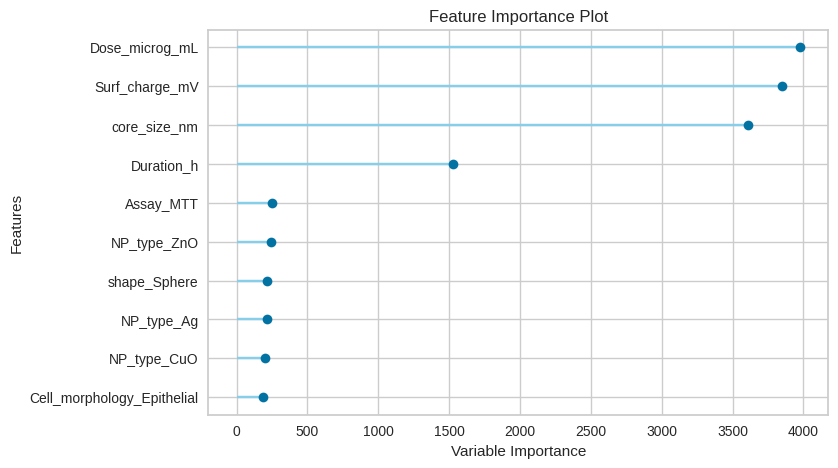

In [52]:
plot_model(tuned_models_load['lightgbm']._final_estimator, 'feature')

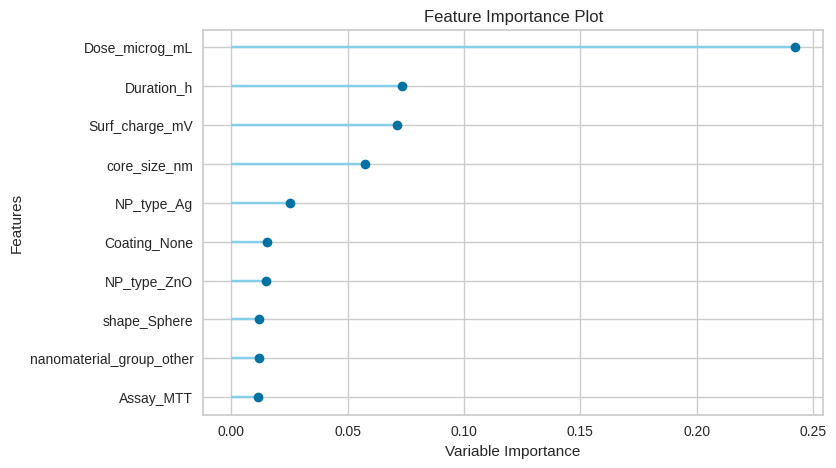

In [53]:
plot_model(tuned_models_load['rf']._final_estimator, 'feature')